In [19]:
import numpy as np
import scipy as sp
import pandas as pd
from glob import glob
from IPython.display import display
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
from scipy import signal


**Data cleaning and understanding**

Reading the EEG data from the provided four electrodes by running the file collected during the long blink session equally long (510 points pro session). Conduct the preliminary data processing and visualization steps to gain some insight from the EEG recording:
- Splits and clean the data
- Selects the first 510 points for visualization

**Questions**
1. Are the amplitude value measure as microvolt?
2. Are the index time series? If yes issit in seconds or milliseconds? 
3. 510 points pro session means? 
4. Do we need to know more information about the four electrodes? 

In [20]:
#Long blink
df1 = pd.read_csv('data\\LongBlink.csv', sep = ",")
df1[['Col1', 'Col2', 'Col3', 'Col4']] = df1['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df1.drop(columns=['data'], inplace=True)
df1.head(5)
ser1 = df1.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
ser2 = df1.iloc[:,1].astype(float) #convert to float
ser3 = df1.iloc[:,2].astype(float) #convert to float
ser4 = df1.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
#ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df1 = pd.concat([ser1, ser2, ser3, ser4], axis=1) #concatenate the columns
df1 = df1.iloc[0:510] #510 points per session 
# df1.plot.line(subplots=True, figsize=(20, 20))

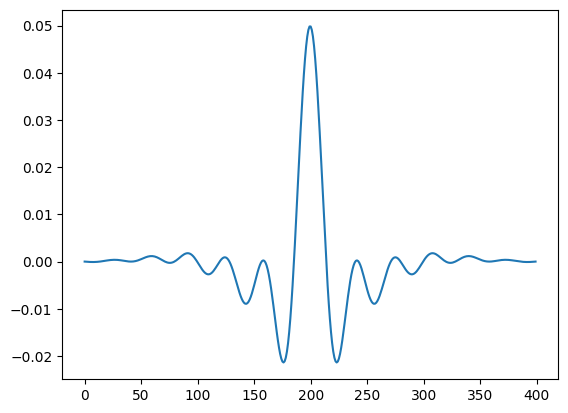

In [24]:
#use signal.firwin function : FIR (finite impulse response) filter to process the signal
filter = signal.firwin(400, [0.01, 0.06], pass_zero=False)
plt.plot(filter)
plt.show()

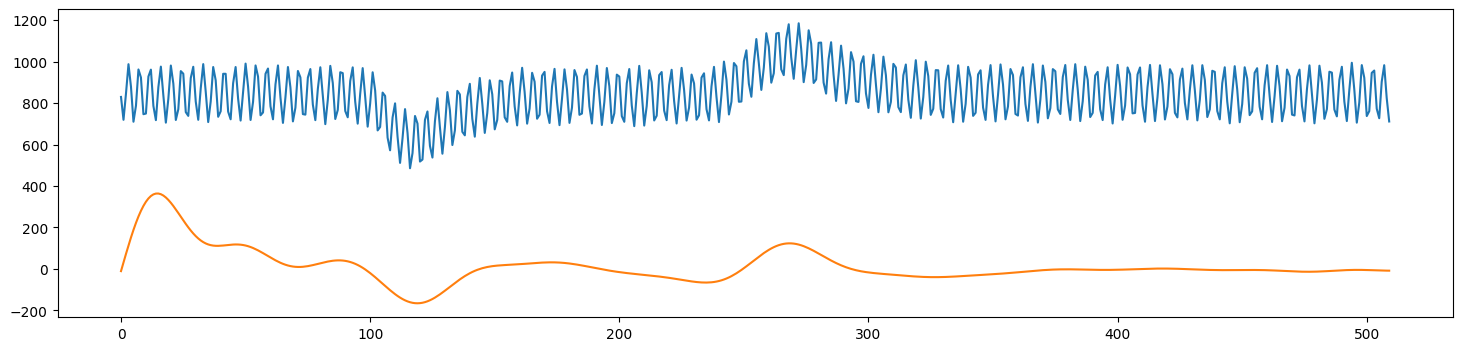

In [30]:
#FIR (finite impulse response) filter to process the first 510 points in series 1 and compare the results
ser1_clean = signal.convolve(ser1, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(ser1[0:510], alpha=1) #alpha is for transparency
plt.plot(ser1_clean[0:510]) 
plt.show()

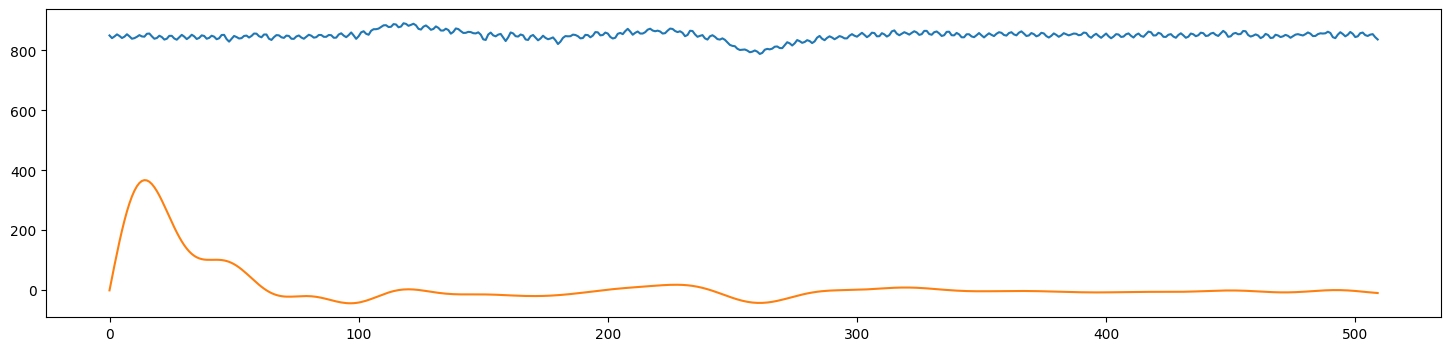

In [32]:
#FIR (finite impulse response) filter to process the first 510 points in series 2 and compare the results
ser2_clean = signal.convolve(ser2, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(ser2[0:510], alpha=1) #alpha is for transparency
plt.plot(ser2_clean[0:510]) 
plt.show()

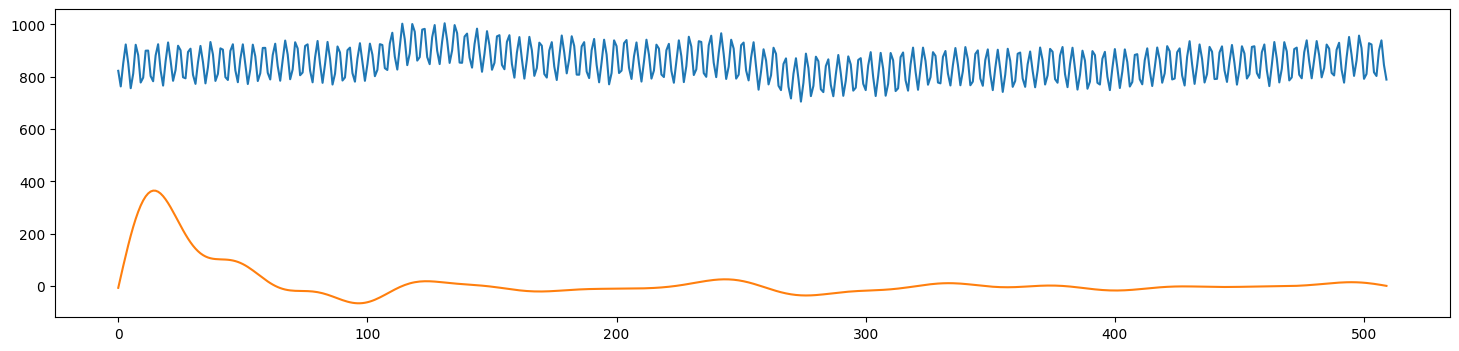

In [33]:
#FIR (finite impulse response) filter to process the first 510 points in series 3 and compare the results
ser3_clean = signal.convolve(ser3, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(ser3[0:510], alpha=1) #alpha is for transparency
plt.plot(ser3_clean[0:510]) 
plt.show()

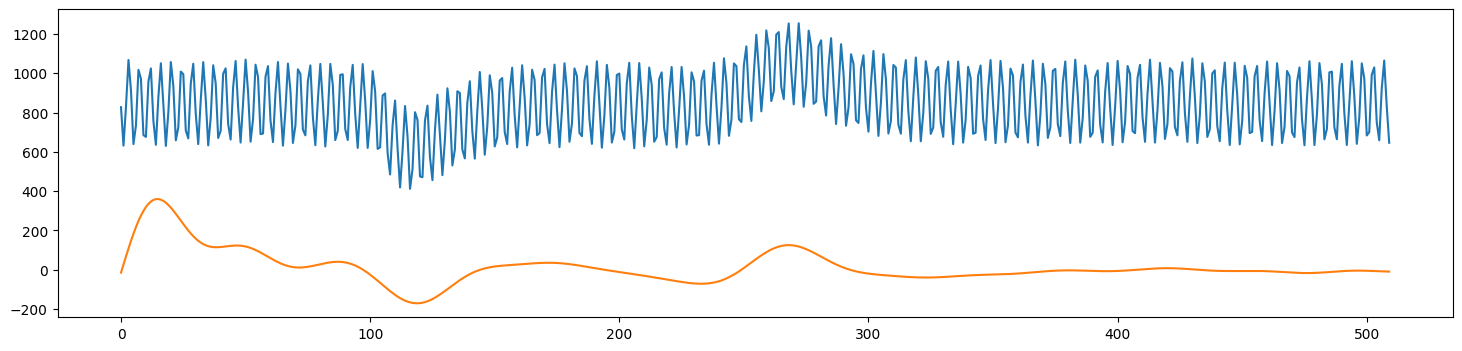

In [34]:
#FIR (finite impulse response) filter to process the first 510 points in series 4 and compare the results
ser4_clean = signal.convolve(ser4, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(ser4[0:510], alpha=1) #alpha is for transparency
plt.plot(ser4_clean[0:510]) 
plt.show()

             Col1        Col2        Col3        Col4
0      830.439560  855.824176  902.161172  844.542125
1      831.245421  859.047619  902.967033  840.915751
2      823.992674  863.882784  896.520147  838.095238
3      814.725275  860.659341  891.282051  831.245421
4      819.963370  859.853480  893.296703  825.604396
...           ...         ...         ...         ...
25495  861.465201  850.989011  857.032967  857.838828
25496  856.227106  856.630037  848.571429  840.512821
25497  848.571429  856.630037  844.945055  835.274725
25498  851.391941  855.018315  847.765568  845.750916
25499  856.630037  855.824176  847.765568  841.318681

[25500 rows x 4 columns]


,Col1,Col2,Col3,Col4
0,830.439560,855.824176,902.161172,844.542125
1,831.245421,859.047619,902.967033,840.915751
2,823.992674,863.882784,896.520147,838.095238
3,814.725275,860.659341,891.282051,831.245421
4,819.963370,859.853480,893.296703,825.604396
...,...,...,...,...
505,828.424908,857.032967,894.102564,844.139194
506,828.827839,852.600733,895.714286,842.124542
507,829.633700,849.780220,901.758242,839.304029
508,834.065934,850.989011,899.340659,838.095238


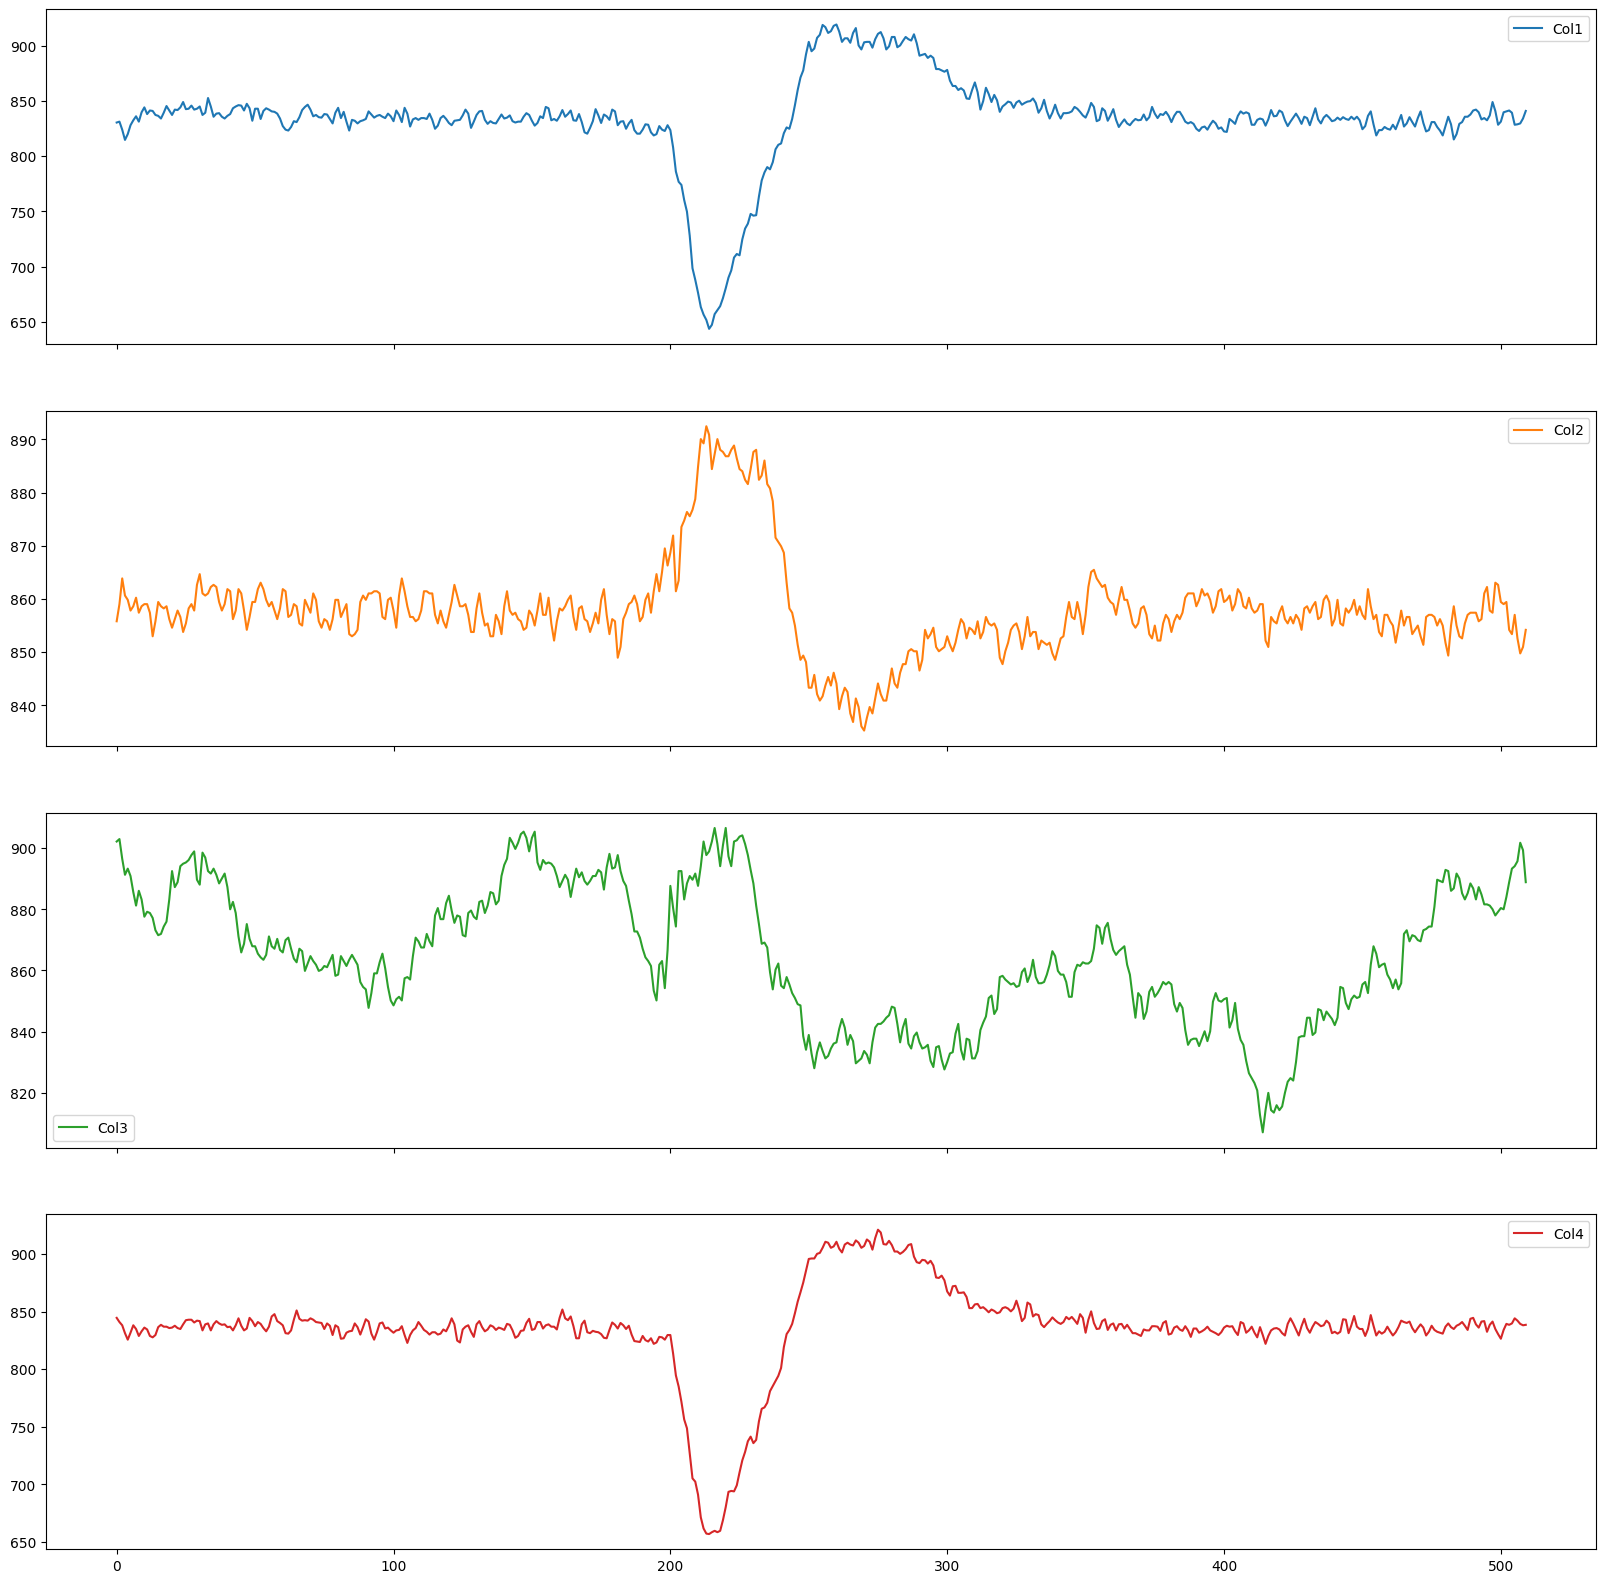

In [5]:
#Short blink
df2 = pd.read_csv('data\\ShortBlink.csv', sep = ",")
df2[['Col1', 'Col2', 'Col3', 'Col4']] = df2['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df2.drop(columns=['data'], inplace=True)
df2.head(5)
ser1 = df2.iloc[:,0].str.strip('[').astype(float) #remove square brackets and convert to float
ser2 = df2.iloc[:,1].astype(float) #convert to float
ser3 = df2.iloc[:,2].astype(float) #convert to float
ser4 = df2.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
df2 = pd.concat([ser1, ser2, ser3, ser4], axis=1)
print(df2)
df2 = df2.iloc[0:510]
df2.plot.line(subplots=True, figsize=(20, 20))
df2

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

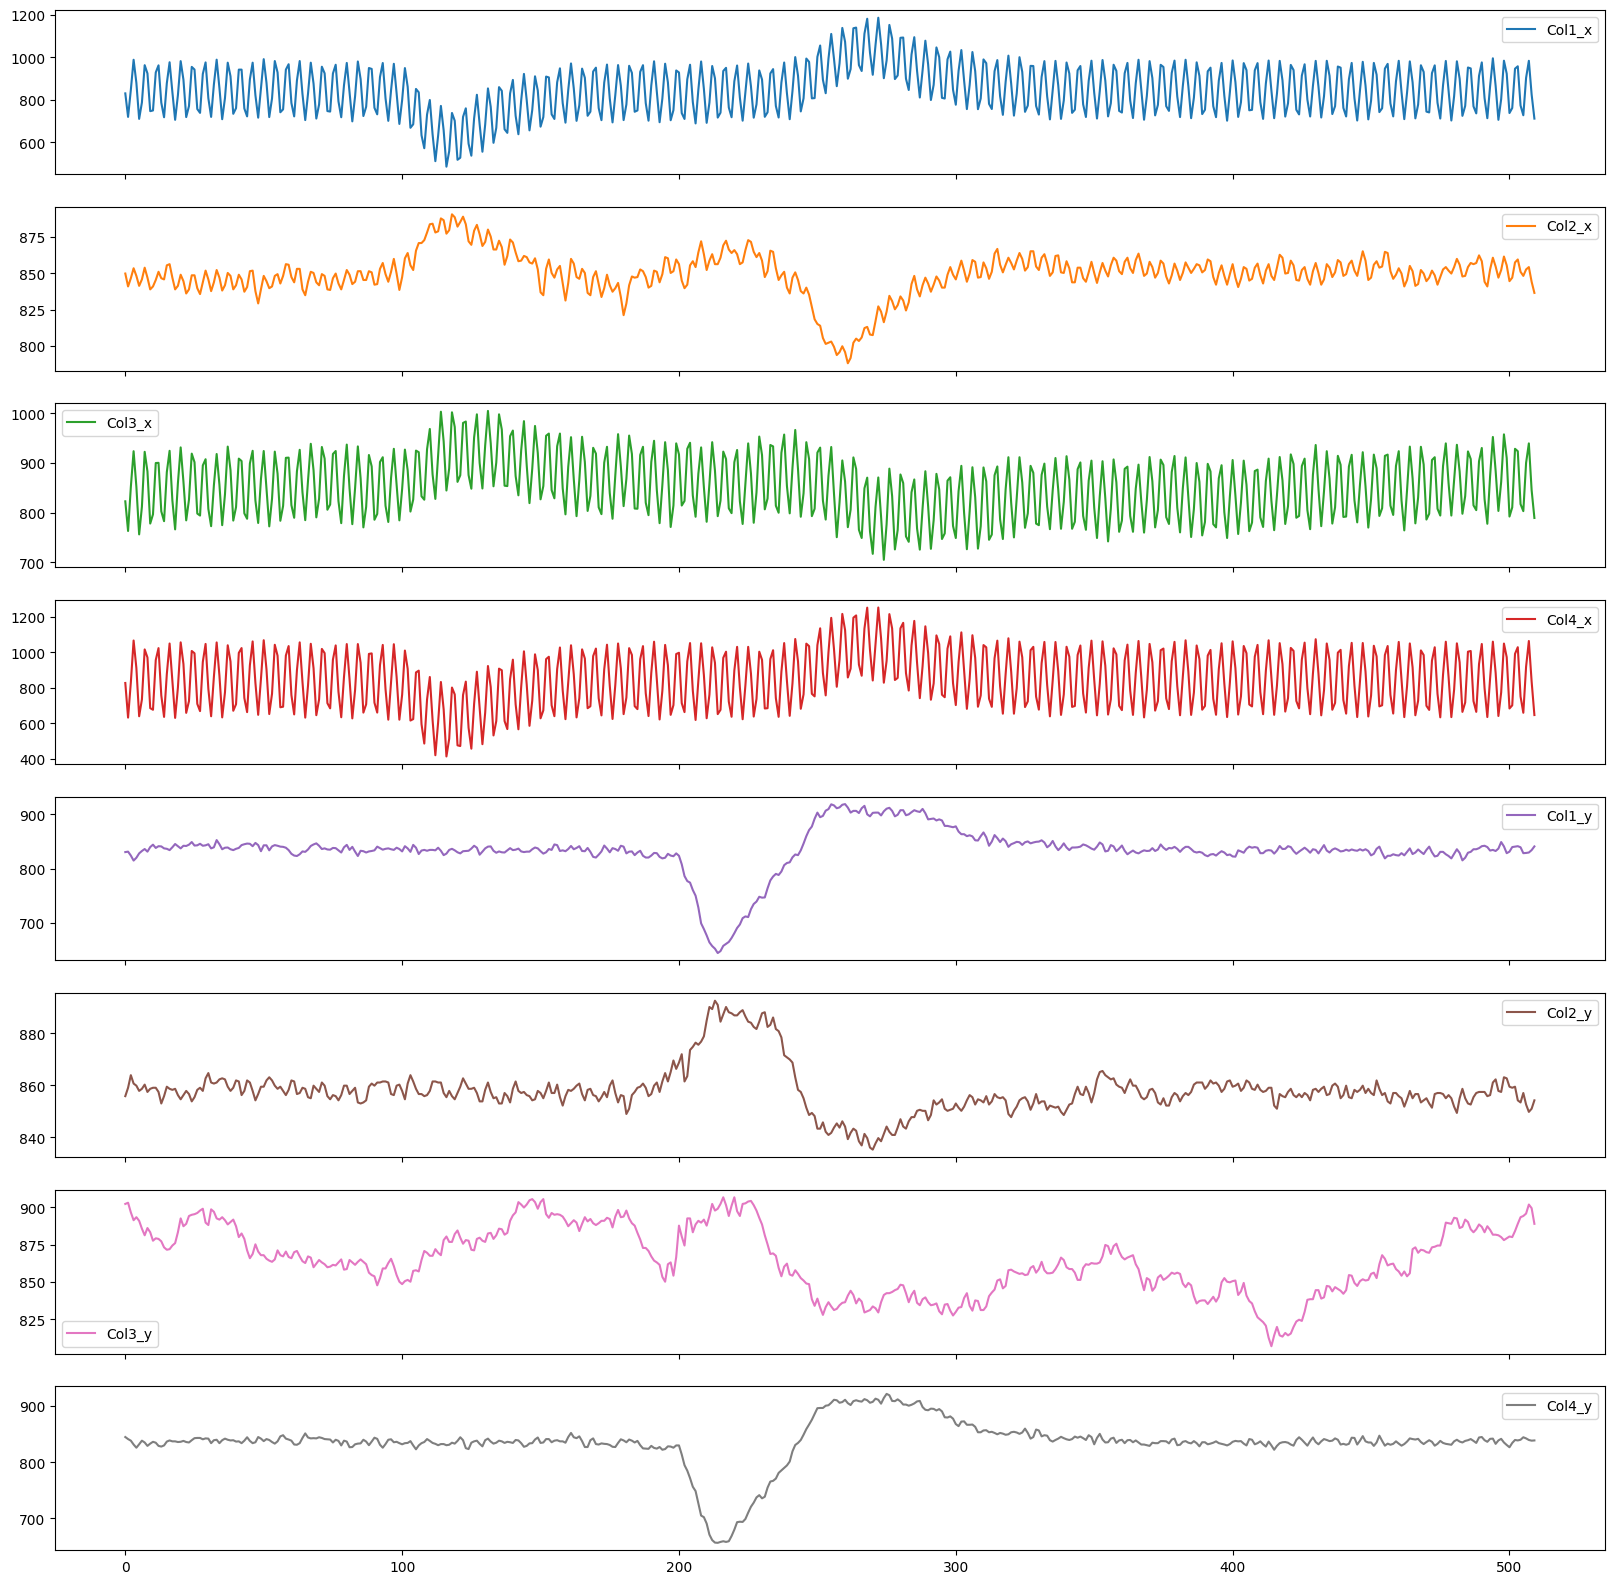

In [6]:
merged_df = pd.merge(df1, df2, how='outer', left_index=True, right_index=True)
merged_df.plot.line(subplots=True, figsize=(20, 20))
